In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization
import visualkeras

In [3]:
labels_csv = pd.read_csv('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\\Codes\\Dog-Breed-Classification-using-Ensemble-Pretrained-Models-main\\labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]
data_train = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')
data_test = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')

data_train1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')
data_test1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')

In [4]:
batch_size = 16
img_size = 224
img_size1 = 299

In [5]:
datagen1 = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)
datagen2 = ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input, validation_split=0.2)
datagen3 = ImageDataGenerator(preprocessing_function = keras.applications.inception_v3.preprocess_input, validation_split=0.2)

def generate_generator_multiple():
    genX1 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))

    genX2 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))

    genX3 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i[0], X2i[0],X3i[0]], X3i[1]  #Yield both images and their mutual label

def generate_generator_multiple2():
    genX1 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))

    genX2 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))

    genX3 = datagen3.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size1, img_size1))
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i[0], X2i[0],X3i[0]], X3i[1]  #Yield both images and their mutual label

inputgenerator=generate_generator_multiple()
validation_generator=generate_generator_multiple()

In [6]:
class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, input_gen3, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = input_gen3
        self.gen4 = target_gen

        assert len(input_gen1) == len(input_gen2) == len(input_gen3) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]
        y = self.gen4[i]

        return [x1, x2, x3],y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()
        self.gen4.on_epoch_end()
        self.gen2.index_array = self.gen1.index_array
        self.gen3.index_array = self.gen1.index_array
        self.gen4.index_array = self.gen1.index_array

In [7]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
inceptionV3 = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(299,299,3))

for layer in vgg16 .layers:
    layer.trainable=False
for layer in resnet50.layers:
    layer.trainable=False
for layer in inceptionV3.layers:
    layer.trainable=False

model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

model1.add(vgg16)
model1.add(BatchNormalization())
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='leaky_relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='leaky_relu'))
model1.add(Dropout(0.5))
model1.add(Dense(120, activation='softmax'))

model2.add(resnet50)
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='leaky_relu'))
model2.add(Dropout(0.5))
model2.add(Dense(120, activation='softmax'))

model3.add(inceptionV3)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='leaky_relu'))
model3.add(Dropout(0.5))
model3.add(Dense(120, activation='softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [8]:
models = []
models.append(model1)
models.append(model2)
models.append(model3)
ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]
merge = tf.keras.layers.concatenate(ensemble_outputs)
merge = tf.keras.layers.BatchNormalization()(merge)
merge = tf.keras.layers.Dense(1024, activation='relu')(merge)
merge = tf.keras.layers.Dropout(0.5)(merge)
output = tf.keras.layers.Dense(120, activation='softmax')(merge)
ensemble_model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vgg16_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['vgg16_input[0][0]']            
                                                                                                  
 batch_normalization_94 (BatchN  (None, 7, 7, 512)   2048        ['vgg16[0][0]']                  
 ormalization)                                                                                    
                                                                                              

In [9]:
history_ens = ensemble_model.fit(inputgenerator, epochs=20, verbose = 1,
                                 steps_per_epoch = 8178/batch_size,
                                 validation_steps = 2044/batch_size,
                                 validation_data=validation_generator)

Found 8178 validated image filenames belonging to 120 classes.
Found 8178 validated image filenames belonging to 120 classes.
Found 8178 validated image filenames belonging to 120 classes.
Epoch 1/20
512/511 [==============================] - ETA: -3s - loss: 4.4706 - accuracy: 0.1352Found 8178 validated image filenames belonging to 120 classes.
Found 8178 validated image filenames belonging to 120 classes.
Found 8178 validated image filenames belonging to 120 classes.
511/511 [==============================] - 2539s 5s/step - loss: 4.4706 - accuracy: 0.1352 - val_loss: 3.9416 - val_accuracy: 0.5391
Epoch 2/20
511/511 [==============================] - 2481s 5s/step - loss: 2.8859 - accuracy: 0.4881 - val_loss: 1.1544 - val_accuracy: 0.7217
Epoch 3/20
511/511 [==============================] - 2528s 5s/step - loss: 1.4188 - accuracy: 0.6687 - val_loss: 0.5423 - val_accuracy: 0.8350
Epoch 4/20
511/511 [==============================] - 2536s 5s/step - loss: 0.9377 - accuracy: 0.7400 - v

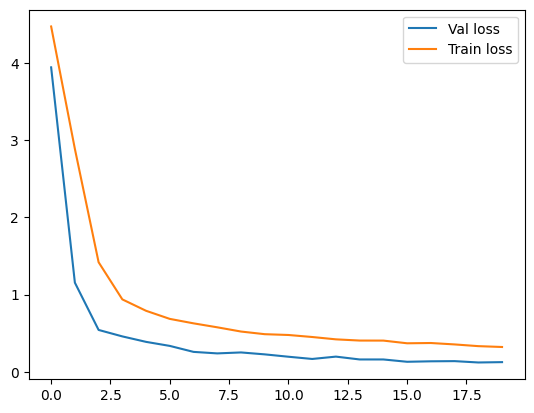

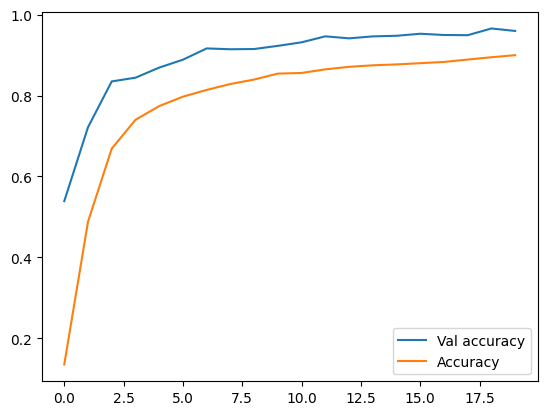

In [10]:
plt.figure()
plt.plot(history_ens .history["val_loss"], label = "Val loss")
plt.plot(history_ens .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ens .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ens .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

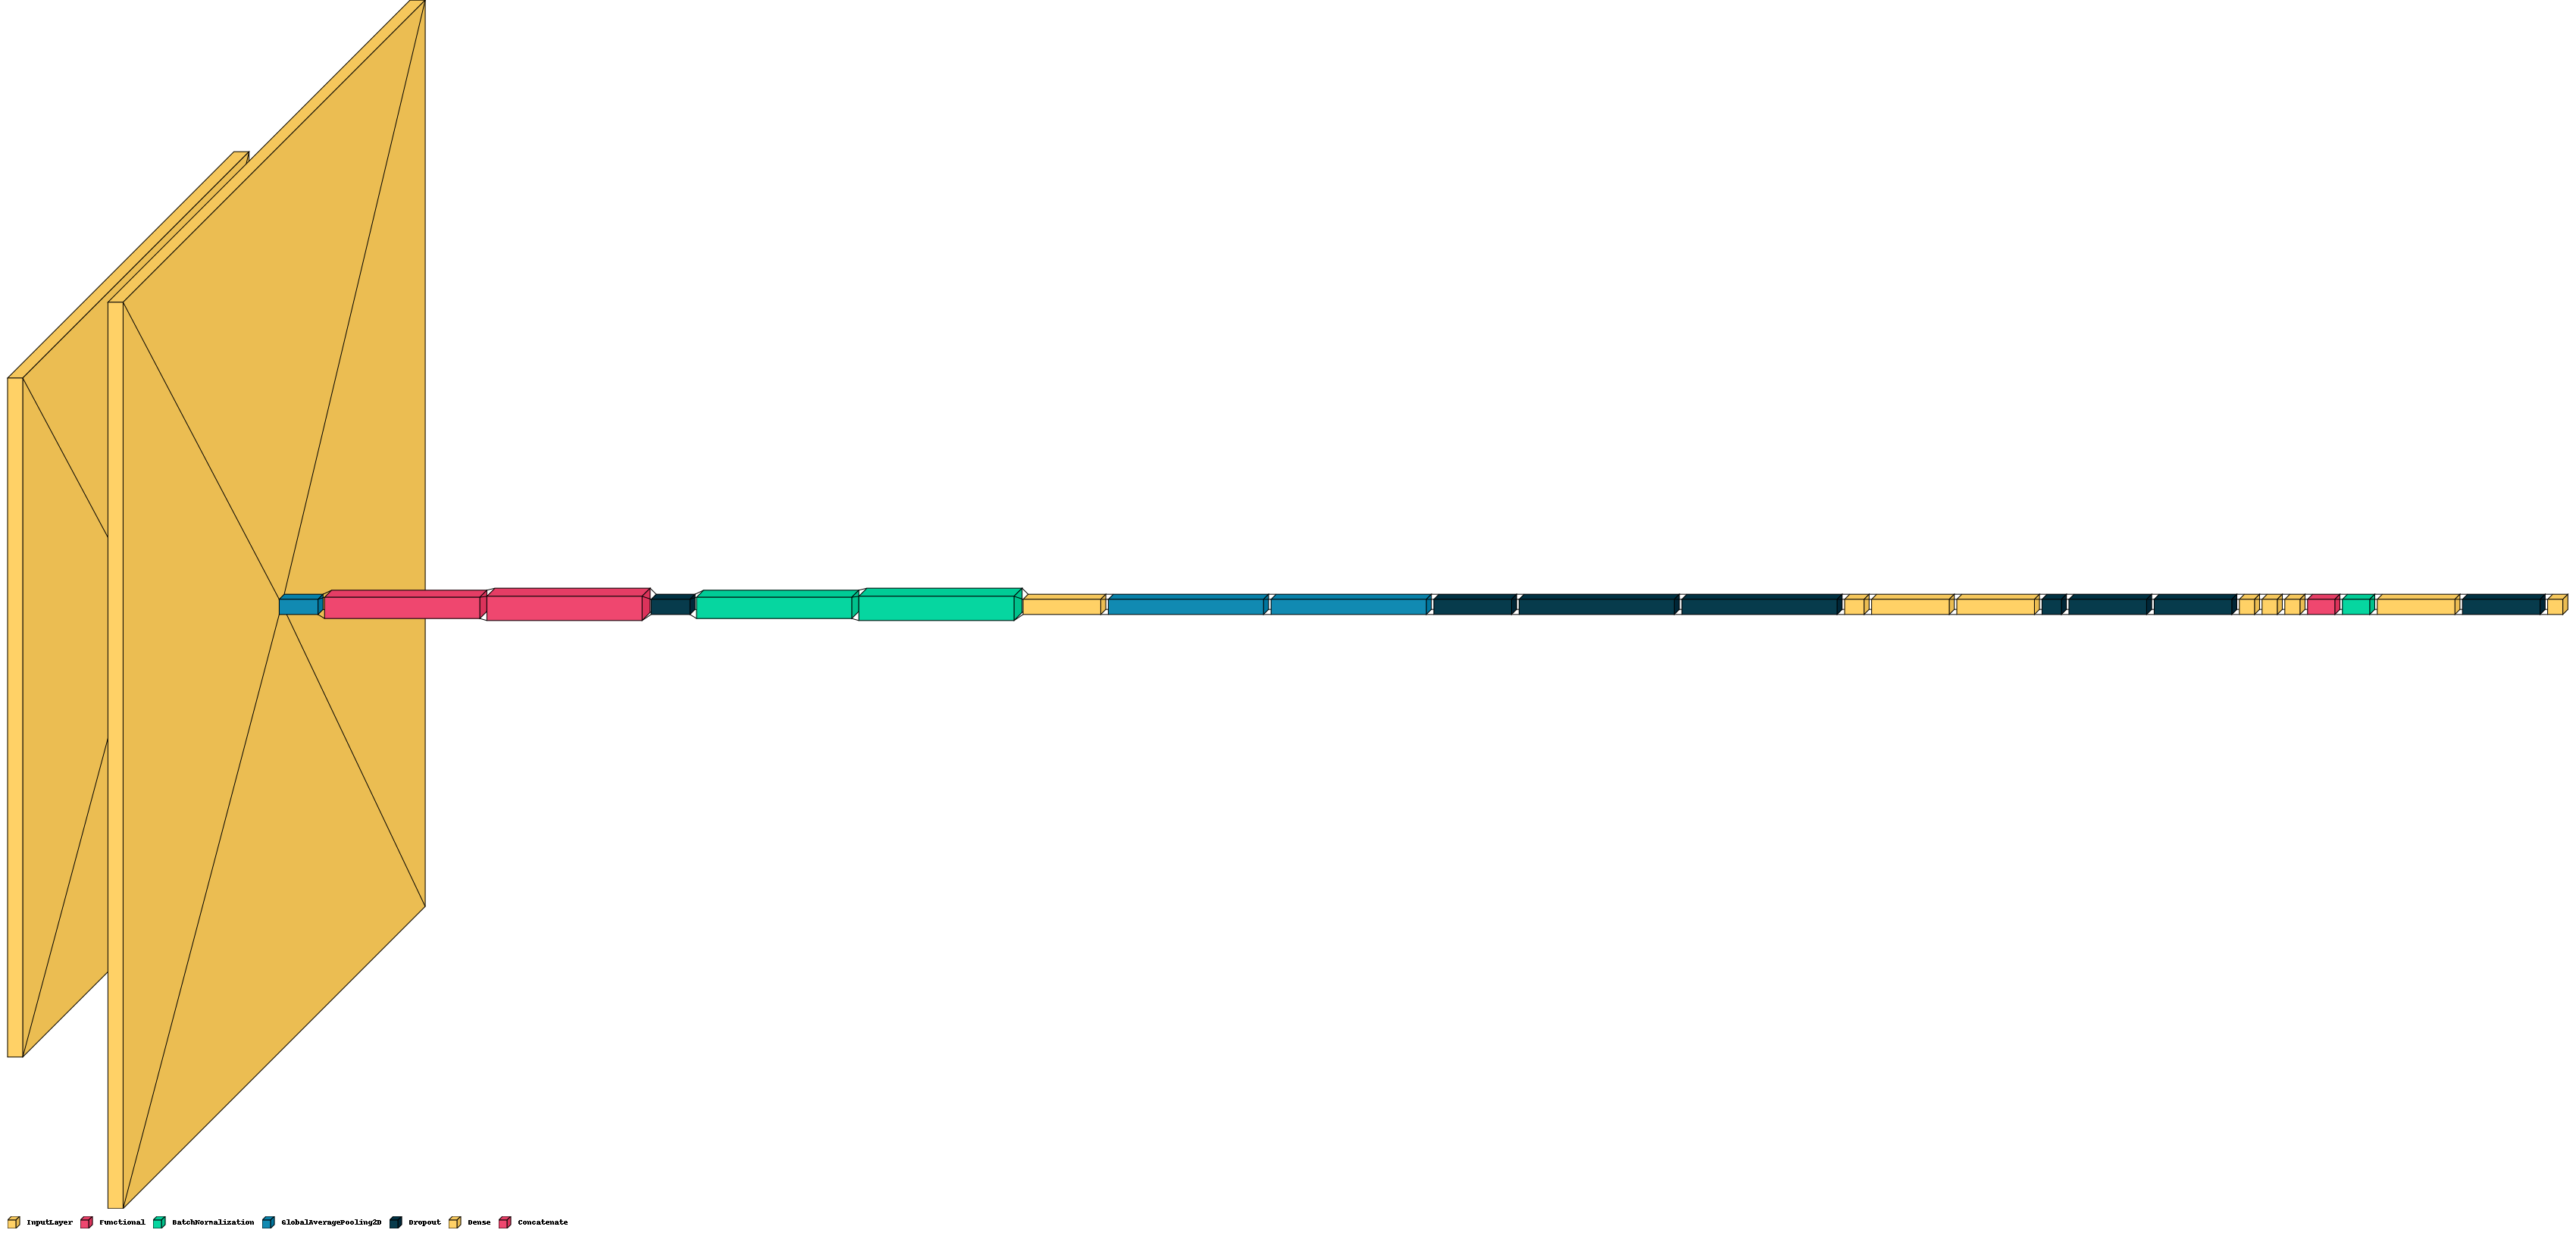

In [11]:
visualkeras.layered_view(ensemble_model,  legend=True)

In [21]:
# Save model
ensemble_model.save('E://dx//Level 6//Project//Topic-Ensemble Model for the Classification of Dog Breed//Codes//Saved Model//StackingReLU299Model.h5')